# Hollister Ranch Analysis

By [Ben Welsh](https://palewi.re/who-is-ben-welsh/)

The _Los Angeles Times_ conducted an analysis of agricultural property tax breaks issued by Santa Barbara County for Steve Lopez's Oct. 20, 2018, column ["At Hollister Ranch, homeowners enjoy private beaches — and hefty tax breaks, too."](http://www.latimes.com/local/california/la-me-lopez-hollister-taxes-20181020-story.html)

It found that Hollister Ranch owners — including celebrities and wealthy business moguls — had their property tax trimmed by roughly 50% this year, reducing the county's revenue by about $2 million.

## Here's how we did it

### Gather Hollister Ranch parcels

A map of all parcels in Santa Barbara County was filtered down to only those in Hollister Ranch using two publically available map files. They were then filtered again to include only parcels that received a property-tax break given to agricultural lands under California's Williamson Act. The names of parcel owners were acquired via a California Public Records Act request with the Santa Barbara County Assessor and merged with the maps.

This was done in consultation with Santa Barbara County officials as well as a lawyer for Hollister Ranch.

In [2]:
%run ./src/parcels.ipynb

### Gather Santa Barbara County property tax records

The list of Hollister Ranch parcels was used to scrape property tax records published by the county assessor. They include the property tax each owner was [billed](http://taxes.co.santa-barbara.ca.us/propertytax/taxbill.asp?FiscalYear=2018&ParcelNumber=083-660-002) in the most recent year. Also harvested was a "value notice" detailing each property's reduced assessment under the Williamson Act, as well as what it would have been assessed at without the break under Proposition 13, the state's reigning property tax law. Comparing these two values is the core of the analysis that follows. The data were gathered in consultation with Santa Barbara County officials.

Here is [an example of a value notice](http://sbcassessor.com/assessor/ValueNotices.aspx?APN=083660002) with the two key values highlighted:

![A value notice](https://i.imgur.com/nXEX9O2.png)

In [3]:
%run ./src/download.ipynb

In [4]:
%run ./src/parse.ipynb

### Import Python tools

In [5]:
import pandas as pd
import altair as alt
from src import settings

A little configuration

In [6]:
pd.options.display.float_format = '${:,.0f}'.format

A few helpers

In [7]:
printmoney = lambda s: print(f'${s:,.0f}')

In [8]:
printpctchange = lambda new, old: print(f'{((new - old) / old)*100:0.2f}%')

### Execute analysis

The scraped data is read in.

In [9]:
williamson_df = pd.read_csv(f"{settings.output_dir}/parsed.csv")

#### How many parcels in Hollister Ranch benefited from the Williamson Act?

In [10]:
len(williamson_df)

136

#### What is the total assessed value of all of the properties under the Williamson Act?

In [11]:
total_williamson_value = williamson_df.williamson_assessment.sum()

In [12]:
printmoney(total_williamson_value)

$182,204,442


#### What would be the total assessed value of those same properties without the benefit?

In [13]:
total_prop13_value = williamson_df.prop13_assessment.sum()

In [14]:
printmoney(total_prop13_value)

$371,160,842


#### What's the difference between those two numbers?

In [15]:
printmoney(total_prop13_value - total_williamson_value)

$188,956,400


#### What's that as a percentage?

In [16]:
printpctchange(total_williamson_value, total_prop13_value)

-50.91%


#### How much property tax was paid under the Williamson rules?

In [17]:
total_williamson_tax = williamson_df.williamson_tax.sum()

In [18]:
printmoney(total_williamson_tax)

$2,016,049


#### The typical home pays roughly 1.1% of its value in property taxes. How much would have been paid at Hollister under typical rules?

In [19]:
estimated_prop13_tax = total_prop13_value * 0.011

In [20]:
printmoney(estimated_prop13_tax)

$4,082,769


#### What's the difference between the two?

In [21]:
printmoney(estimated_prop13_tax - total_williamson_tax)

$2,066,720


#### What's that as a percentage?

In [22]:
printpctchange(total_williamson_tax, estimated_prop13_tax)

-50.62%


#### Who got the biggest assessment breaks?

In [23]:
williamson_df['assessment_break'] = williamson_df.williamson_assessment - williamson_df.prop13_assessment

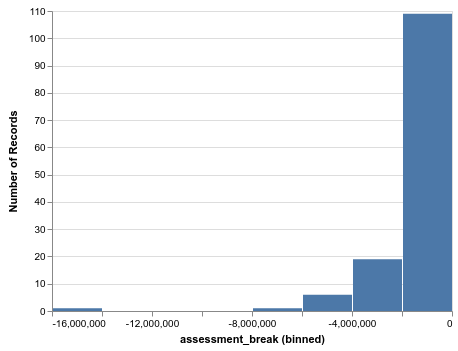

In [24]:
alt.Chart(williamson_df).mark_bar().encode(
    alt.X("assessment_break:Q", bin=True),
    y='count()',
)

In [25]:
williamson_df.assessment_break.describe().reset_index()

,index,assessment_break
0,count,$136
1,mean,"$-1,389,385"
2,std,"$1,668,667"
3,min,"$-15,048,700"
4,25%,"$-1,797,666"
5,50%,"$-924,590"
6,75%,"$-419,249"
7,max,"$-8,246"


In [26]:
williamson_df.sort_values("assessment_break").head()[[
    'apn',
    'primary_owner',
    'williamson_assessment',
    'prop13_assessment',
    'assessment_break'
]]

,apn,primary_owner,williamson_assessment,prop13_assessment,assessment_break
107,83680025,HOLLISTER RANCH TRUST 1/5/16,"$6,799,698","$21,848,398","$-15,048,700"
85,83680005,HOLLISTER RANCH 54 GP CA,"$1,823,680","$8,147,960","$-6,324,280"
106,83680024,"DASH HOLDINGS III, LLC","$4,401,121","$10,092,512","$-5,691,391"
3,83700002,"HAYDEN PROPERTIES, LLC","$2,315,560","$6,746,081","$-4,430,521"
104,83680022,HOWARD RANCH LLC,"$2,409,530","$6,788,460","$-4,378,930"


#### Who got the biggest tax breaks?

In [27]:
williamson_df['prop13_tax_estimate'] = williamson_df.prop13_assessment * 0.011

In [28]:
williamson_df['tax_break_estimate'] = williamson_df.williamson_tax - williamson_df.prop13_tax_estimate

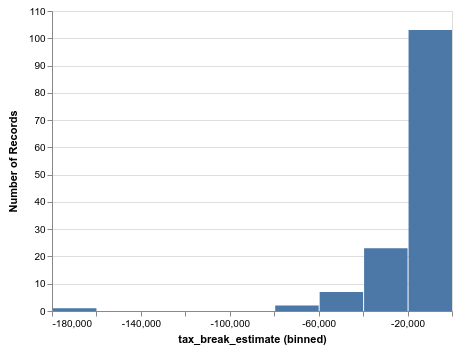

In [29]:
alt.Chart(williamson_df).mark_bar().encode(
    alt.X("tax_break_estimate:Q", bin=True),
    y='count()',
)

In [30]:
williamson_df['tax_break_estimate'].describe().reset_index()

,index,tax_break_estimate
0,count,$136
1,mean,"$-15,196"
2,std,"$18,302"
3,min,"$-165,064"
4,25%,"$-19,551"
5,50%,"$-10,162"
6,75%,"$-4,610"
7,max,$-83


In [31]:
williamson_df.sort_values("tax_break_estimate").head()[[
    'apn',
    'primary_owner',
    'williamson_tax',
    'prop13_tax_estimate',
    'tax_break_estimate'
]]

,apn,primary_owner,williamson_tax,prop13_tax_estimate,tax_break_estimate
107,83680025,HOLLISTER RANCH TRUST 1/5/16,"$75,269","$240,332","$-165,064"
85,83680005,HOLLISTER RANCH 54 GP CA,"$20,187","$89,628","$-69,441"
106,83680024,"DASH HOLDINGS III, LLC","$48,718","$111,018","$-62,300"
3,83700002,"HAYDEN PROPERTIES, LLC","$25,632","$74,207","$-48,575"
104,83680022,HOWARD RANCH LLC,"$26,672","$74,673","$-48,001"


### Output the results

In [32]:
williamson_df.to_csv(f"{settings.output_dir}/analyzed.csv", index=False, encoding="utf-8")